# Package

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import norm
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.stattools import jarque_bera
from scipy.stats import shapiro, normaltest, anderson, kstest, norm

import time
from IPython.display import display, clear_output
from sklearn.metrics import mean_squared_error

from sklearn.metrics import mean_squared_error

# Importation

In [2]:
# Lire le fichier brut
with open("lbl-tcp-3.tcp", "r", encoding="latin-1") as f:
    lignes = f.readlines()

# Afficher quelques lignes pour voir la structure
for i, ligne in enumerate(lignes[:5]):  # juste les 20 premières
    print(i, ligne.strip())

0 759103800.008185 1 2 23 2436 1
1 0.010445 2 1 2436 23 2
2 0.023775 1 2 23 2436 2
3 0.026558 2 1 2436 23 1
4 0.029002 3 4 3930 119 42


In [3]:
# Chargement brut : 6 colonnes, séparateur = espaces ----
path = "lbl-tcp-3.tcp"

colnames = ["ts", "src_id", "dst_id", "src_port", "dst_port", "val"]
df = pd.read_csv(
    path,
    sep=r"\s+",            # espaces multiples
    header=None,
    names=colnames,
    engine="python",
    dtype={
        "ts": float,
        "src_id": np.int64,
        "dst_id": np.int64,
        "src_port": np.int64,
        "dst_port": np.int64,
        "val": np.int64
    }
)

In [4]:
# On doit donc analyser par paquet
# 1) Point de départ
t0 = df['ts'].min()

# 2) Intervalles de 10 s (fenêtres [0,10), [10,20), …, [7190,7200))
df['Interval'] = np.floor((df['ts'] - t0 - 1e-9) / 10).astype(int)

# 3) Garder seulement 720 intervalles (0..719)
df = df[df['Interval'].between(0, 719)]

In [5]:
# Série de longueur 720 : nombre de lignes par fenêtre de 10 s
ts_series = (
    df.groupby('Interval')
      .size()
      .reindex(range(720), fill_value=0)  # assure les fenêtres vides
)

# Index en temps relatif (0s, 10s, 20s, …)
ts_series.index = pd.to_timedelta(ts_series.index * 10, unit='s')
ts_series.name = 'count'

In [6]:
# 1) DatetimeIndex ancré + freq explicite
anchor = pd.Timestamp('2025-09-10 00:00:00')
idx = pd.date_range(start=anchor, periods=len(ts_series), freq='10S')
ts_series = ts_series.copy()
ts_series.index = idx             # DatetimeIndex régulier

C:\Users\Mita\AppData\Local\Temp\ipykernel_15616\1262908431.py:3: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  idx = pd.date_range(start=anchor, periods=len(ts_series), freq='10S')


In [7]:
ts_series

2025-09-10 00:00:00    1618
2025-09-10 00:00:10    1724
2025-09-10 00:00:20    3224
2025-09-10 00:00:30    1763
2025-09-10 00:00:40    1891
                       ... 
2025-09-10 01:59:10    3161
2025-09-10 01:59:20    2650
2025-09-10 01:59:30    2633
2025-09-10 01:59:40    2166
2025-09-10 01:59:50    2820
Freq: 10s, Name: count, Length: 720, dtype: int64

In [8]:
# Spécificité de la série temporelle
print(pd.infer_freq(ts_series.index))
print(ts_series.index[0])
print(ts_series.index[-1])

10s
2025-09-10 00:00:00
2025-09-10 01:59:50


La fréquence de notre série temporelle est maintenant de 10 seconde. Elle dure environ deux (02) heures.

# Graphique du Time Series

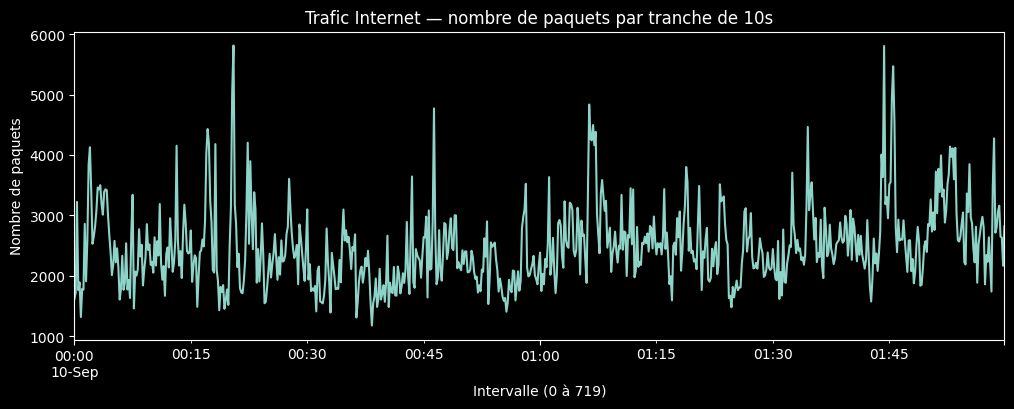

In [10]:
plt.figure(figsize=(12,4))
plt.style.use("dark_background")
ts_series.plot()
plt.title("Trafic Internet — nombre de paquets par tranche de 10s")
plt.xlabel("Intervalle (0 à 719)")
plt.ylabel("Nombre de paquets")
plt.show()

Le signal est une série temporelle du trafic réseau TCP.
- Chaque observation = le nombre de paquets transmis dans un intervalle de 10 secondes. C’est un comptage d’événements (paquets), donc un signal discret et positif (0, 1, 2, …). Il représente la charge instantanée du réseau : quand le nombre est élevé, le réseau transporte beaucoup de paquets → activité forte.
- L’échelle du temps : environ 2 heures de trafic, découpées en 720 intervalles.
- La grandeur mesurée : pas la taille des données en Mo/Go, mais le volume d’activité du réseau en termes de paquets échangés.

On constate :
- Pas de tendance : le trafic n’augmente pas avec le temps.
- Pas de saisonnalité : on n’observe pas de cycles réguliers.
- Stationnarité : les caractéristiques du trafic (moyenne/variance) semblent stables au cours du temps.
- Grande volatilité : les valeurs varient beaucoup d’un intervalle de 10 secondes à l’autre.

# Stationnarité

In [13]:
result = adfuller(ts_series)

print("Statistique ADF:", result[0])
print("p-value:", result[1])
print("Valeurs critiques:", result[4])
if result[1] < 0.05:
    print("On rejette H0 : la série est stationnaire.")
else:
    print("On ne rejette pas H0 : la série est non-stationnaire.")

Statistique ADF: -8.273264859803446
p-value: 4.730303272479693e-13
Valeurs critiques: {'1%': np.float64(-3.439516060164992), '5%': np.float64(-2.8655850998755263), '10%': np.float64(-2.5689240826597173)}
On rejette H0 : la série est stationnaire.


# Analyse de l'autocorrélation

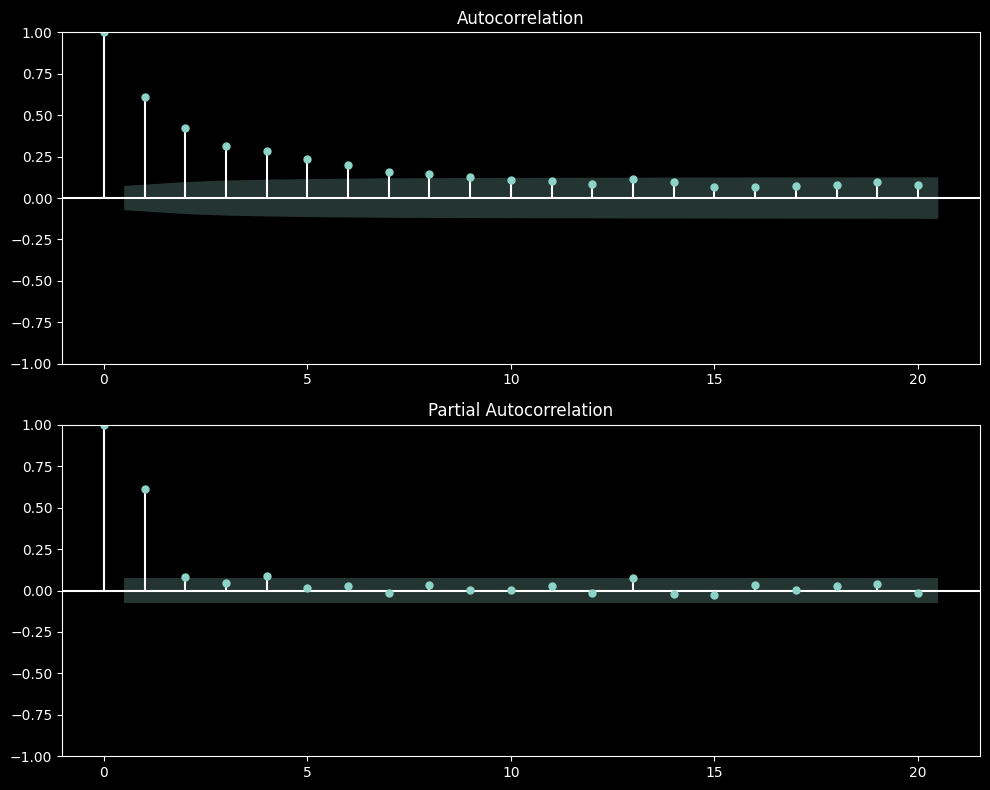

In [14]:
fig, ax = plt.subplots(nrows=2, figsize=(10, 8))
plt.style.use("dark_background")
plot_acf(ts_series, ax=ax[0], lags=20, alpha=0.05)
plot_pacf(ts_series, ax=ax[1], lags=20, alpha=0.05)

plt.tight_layout()
plt.show()

Ces graphiques montrent la corrélation de la série temporelle avec elle-même avec un retards maximal de 20. Lorsque les valeurs sont proches de 0, celà veut dire que les observations consécutives sont non corrélées. Par contre, lorsqu'elles sont proches de 1 ou -1, l'autocorrélation est présente.  

L'ACF et le PACF retournent à chacun des intervalles de confiance. La corrélation est significative lorsqu'elle déborde de cette intervalle. 

Pour le PACF, le retards égal à 1 est très significatifs et le reste est relativement faible. Une petite élevation se situe au 13è lags. L'autocorrélation s'accumule jusqu'à la 7è lags comme le montre le graphique de l'autocorrélation. 

Ces résultats justifient l'utilisation des modèles auto-régressifs. Pour AR(p), p devrait être au plus égal à 7. Nous allons donc chercher maintenant la valeur optimale de p.  

# Choix de paramètre du modèle AR(p)

## Critère AIC

In [15]:
# ============================================
# Étape 1 — Préparation des données et des paramètres
# ============================================
y = pd.Series(ts_series, dtype = float).dropna()
n = len(y)
h = int(0.7 * n)
y_train, y_test = y[:h], y[h:]
idx_train, idx_test = y_train.index, y_test.index
pmax = 7
len(y_train) , len(y_test)

(503, 217)

In [16]:
# Etape 2 : AIC
for p in range (1, pmax + 1):
    mod = ARIMA (endog = y_train, order = (p, 0, 0))
    res = mod.fit()
    print(f"aic ({p}) : {res.aic}")

aic (1) : 7718.717921796355
aic (2) : 7719.6001415317905
aic (3) : 7719.536466548482
aic (4) : 7720.27131874207
aic (5) : 7721.29102069
aic (6) : 7723.269525019778
aic (7) : 7724.712765942651


Plus la valeur de p augmente, plus AIC augmente en principe. Mais de p = 6 à 7, il commence à diminuer. Ce qui laisse présager que l'on peut trouver un meilleur p à 13? Essayons.

In [17]:
# Etape 2 : AIC
pmax = 13
for p in range (1, pmax + 1):
    mod = ARIMA (endog = y_train, order = (p, 0, 0))
    res = mod.fit()
    print(f"aic ({p}) : {res.aic}")

aic (1) : 7718.717921796355
aic (2) : 7719.6001415317905
aic (3) : 7719.536466548482
aic (4) : 7720.27131874207
aic (5) : 7721.29102069
aic (6) : 7723.269525019778
aic (7) : 7724.712765942651
aic (8) : 7726.153043987129
aic (9) : 7727.870332872258
aic (10) : 7729.639387469292
aic (11) : 7731.56826021491
aic (12) : 7733.714767399062
aic (13) : 7732.772247868854


Pour AIC, AR(p) = AR(1). Essayons avec BIC.

In [18]:
# BIC
for p in range (1, pmax + 1):
    mod = ARIMA (endog = y_train, order = (p, 0, 0))
    res = mod.fit()
    print(f"aic ({p}) : {res.bic}")

aic (1) : 7731.379692306654
aic (2) : 7736.4825022121895
aic (3) : 7740.639417398981
aic (4) : 7745.594859762668
aic (5) : 7750.835151880698
aic (6) : 7757.0342463805755
aic (7) : 7762.698077473548
aic (8) : 7768.358945688126
aic (9) : 7774.296824743355
aic (10) : 7780.286469510489
aic (11) : 7786.435932426207
aic (12) : 7792.803029780458
aic (13) : 7796.08110042035


Pareil, BIC confirme qu'il faut avoir AR(1). Voyons voir maintenant le cas de Backtesting

In [83]:
# Etablir une fonction de Backtesting pour le choix de p dans AR(p)
def ts_backtesting (s, pmax, nchunks) :
    s = pd.Series(s).dropna()
    s = s.asfreq("10s")
    n = len(s)
    cuts = np.linspace(0, n , nchunks + 1, dtype = int) # Puisque iloc en bas exige un float
    results = []

    for k in range ( nchunks - 1 ) : 
        for p in range (1 , pmax + 1) : 
            train = s.iloc[:cuts[k+1]]
            validation = s.iloc[cuts[k+1]:cuts[k+2]]

            try : 
                mod = ARIMA(train, order = (p,0,0))
                res = mod.fit()

                forecast_values = pd.Series(res.forecast(steps = len(validation)))
                forecast = pd.Series(forecast_values, index=validation.index)
                rmse_fold = np.sqrt(((validation - forecast) ** 2).mean())
                
                results.append((p, rmse_fold))
        
            except Exception : 
                rmse.append(np.nan)

    df_results = pd.DataFrame(results, columns=["p", "rmse"])
    return df_results.groupby("p")["rmse"].mean()

In [84]:
# Appeler la fonction de Backtesting
ts_backtesting(y_train, pmax=pmax, nchunks = 5)

p
1     629.955510
2     629.281030
3     627.249248
4     625.577919
5     625.853231
6     626.212788
7     628.166444
8     626.321087
9     626.405600
10    626.049591
11    625.731103
12    626.683405
13    626.434834
Name: rmse, dtype: float64

Ici, c'est p = 11 qui donne le RMSE le plus bas. 

# Tester les modèles et choisir

## Réentrainement des modèles

In [85]:
# AIC et BIC
mod_ar_aic_bic = ARIMA(endog = y_train, order = (1,0,0))
res_ar_aic_bic = mod_ar_aic_bic.fit()

In [86]:
# backtesting
mod_ar_rmse = ARIMA(endog=y_train, order = (11,0,0))
res_ar_rmse = mod_ar_rmse.fit()

# Validation modèle

In [87]:
# Sauver les résidus des 02 modèles
ar_resid_aic = res_ar_aic_bic.resid
ar_resid_rmse = res_ar_rmse.resid

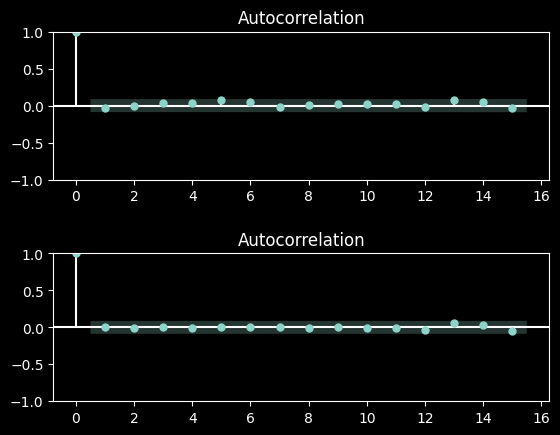

In [88]:
# Analyser l'autocorrélation
fig = plt.figure()

plt.style.use("dark_background")

ax1 = fig.add_subplot(2,1,1)
plot_acf(ar_resid_aic, lags = 15 , ax=ax1)

ax2 = fig.add_subplot(2,1,2)
plot_acf(ar_resid_rmse, lags = 15, ax=ax2)

plt.subplots_adjust(hspace=0.5)

plt.show()

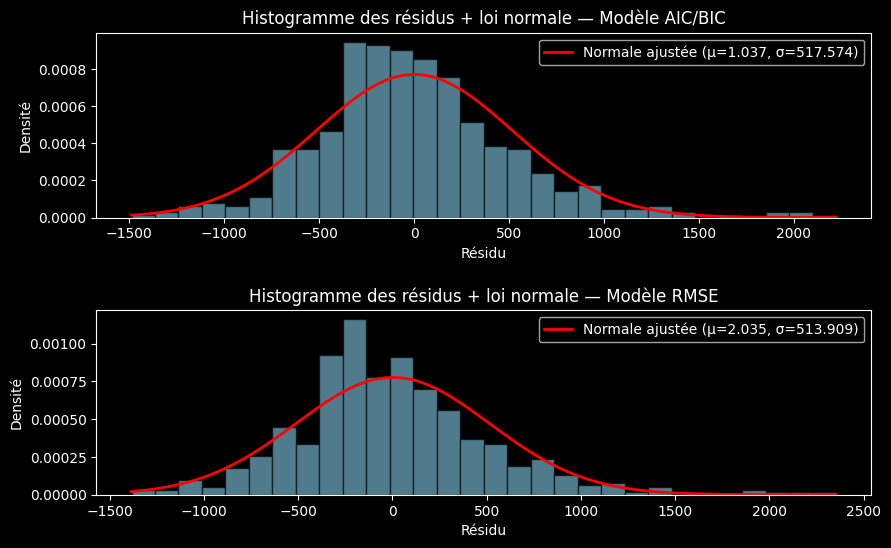

In [22]:
# Résidus (on sécurise en retirant d'éventuels NaN)
ar_resid_aic  = res_ar_aic_bic.resid.dropna()
ar_resid_rmse = res_ar_rmse.resid.dropna()

# Paramètres d'affichage
bins = 30

fig = plt.figure(figsize=(10, 6))

# --- 1) Histogramme + normale ajustée : modèle "AIC/BIC" ---
ax1 = fig.add_subplot(2, 1, 1)
mu1, sigma1 = ar_resid_aic.mean(), ar_resid_aic.std()
ax1.hist(ar_resid_aic, bins=bins, density=True, alpha=0.6, color="skyblue", edgecolor="black")
x1 = np.linspace(ar_resid_aic.min(), ar_resid_aic.max(), 200)
ax1.plot(x1, norm.pdf(x1, mu1, sigma1), "r-", lw=2,
         label=f"Normale ajustée (μ={mu1:.3f}, σ={sigma1:.3f})")
ax1.set_title("Histogramme des résidus + loi normale — Modèle AIC/BIC")
ax1.set_xlabel("Résidu")
ax1.set_ylabel("Densité")
ax1.legend()

# --- 2) Histogramme + normale ajustée : modèle "RMSE" ---
ax2 = fig.add_subplot(2, 1, 2)
mu2, sigma2 = ar_resid_rmse.mean(), ar_resid_rmse.std()
ax2.hist(ar_resid_rmse, bins=bins, density=True, alpha=0.6, color="skyblue", edgecolor="black")
x2 = np.linspace(ar_resid_rmse.min(), ar_resid_rmse.max(), 200)
ax2.plot(x2, norm.pdf(x2, mu2, sigma2), "r-", lw=2,
         label=f"Normale ajustée (μ={mu2:.3f}, σ={sigma2:.3f})")
ax2.set_title("Histogramme des résidus + loi normale — Modèle RMSE")
ax2.set_xlabel("Résidu")
ax2.set_ylabel("Densité")
ax2.legend()

plt.subplots_adjust(hspace=0.5)
plt.show()

In [23]:
def test_residus(name, resid, lags=[3], alpha=0.05):
    r = resid.dropna()

    print(f"\n===== Tests résidus — {name} =====")

    # --- Test d’autocorrélation (Ljung-Box) ---
    lb = acorr_ljungbox(r, lags=lags, return_df=True)
    print("\n--- Ljung-Box ---")
    print(lb)

    # --- Jarque-Bera (statsmodels) ---
    jb_stat, jb_pvalue, skew, kurtosis = jarque_bera(r)
    print("\n--- Jarque-Bera ---")
    print(f"Statistique : {jb_stat:.3f}")
    print(f"p-value     : {jb_pvalue:.3f}")
    print(f"Asymétrie   : {skew:.3f}")
    print(f"Kurtosis    : {kurtosis:.3f}")

    # --- Shapiro-Wilk ---
    shapiro_stat, shapiro_p = shapiro(r)
    print("\n--- Shapiro-Wilk ---")
    print(f"Statistique : {shapiro_stat:.3f}")
    print(f"p-value     : {shapiro_p:.3f}")

    # --- D’Agostino & Pearson ---
    dagostino_stat, dagostino_p = normaltest(r)
    print("\n--- D’Agostino & Pearson ---")
    print(f"Statistique : {dagostino_stat:.3f}")
    print(f"p-value     : {dagostino_p:.3f}")

    # --- Anderson-Darling ---
    ad_res = anderson(r, dist='norm')
    print("\n--- Anderson-Darling ---")
    print(f"Statistique : {ad_res.statistic:.3f}")
    for cv, sig in zip(ad_res.critical_values, ad_res.significance_level):
        print(f"  Niveau {sig}% : Critique = {cv:.3f}")

    # --- Kolmogorov-Smirnov ---
    mu, sigma = r.mean(), r.std()
    ks_stat, ks_p = kstest(r, 'norm', args=(mu, sigma))
    print("\n--- Kolmogorov-Smirnov ---")
    print(f"Statistique : {ks_stat:.3f}")
    print(f"p-value     : {ks_p:.3f}")

    # --- Commentaires automatiques ---
    print("\n=== Conclusion automatique ===")

    # Autocorrélation
    if lb['lb_pvalue'].iloc[-1] > alpha:
        print("→ Résidus ~ bruit blanc (pas d'autocorrélation détectée).")
    else:
        print("→ Résidus autocorrélés (modèle à améliorer).")

    # Normalité (Jarque-Bera comme référence principale)
    if jb_pvalue > alpha:
        print("→ Résidus ~ distribution normale (selon Jarque-Bera).")
    else:
        print("→ Résidus non normaux (selon Jarque-Bera).")

In [24]:
# Lancer pour les deux séries
test_residus("Modèle AIC/BIC", ar_resid_aic, lags=[1])


===== Tests résidus — Modèle AIC/BIC =====

--- Ljung-Box ---
    lb_stat  lb_pvalue
1  0.378741   0.538278

--- Jarque-Bera ---
Statistique : 118.833
p-value     : 0.000
Asymétrie   : 0.716
Kurtosis    : 4.902

--- Shapiro-Wilk ---
Statistique : 0.966
p-value     : 0.000

--- D’Agostino & Pearson ---
Statistique : 61.620
p-value     : 0.000

--- Anderson-Darling ---
Statistique : 3.836
  Niveau 15.0% : Critique = 0.572
  Niveau 10.0% : Critique = 0.651
  Niveau 5.0% : Critique = 0.781
  Niveau 2.5% : Critique = 0.911
  Niveau 1.0% : Critique = 1.083

--- Kolmogorov-Smirnov ---
Statistique : 0.073
p-value     : 0.008

=== Conclusion automatique ===
→ Résidus ~ bruit blanc (pas d'autocorrélation détectée).
→ Résidus non normaux (selon Jarque-Bera).


In [25]:
test_residus("Modèle RMSE",    ar_resid_rmse, lags=[11])


===== Tests résidus — Modèle RMSE =====

--- Ljung-Box ---
     lb_stat  lb_pvalue
11  0.139709        1.0

--- Jarque-Bera ---
Statistique : 157.720
p-value     : 0.000
Asymétrie   : 0.833
Kurtosis    : 5.179

--- Shapiro-Wilk ---
Statistique : 0.960
p-value     : 0.000

--- D’Agostino & Pearson ---
Statistique : 75.937
p-value     : 0.000

--- Anderson-Darling ---
Statistique : 4.450
  Niveau 15.0% : Critique = 0.572
  Niveau 10.0% : Critique = 0.651
  Niveau 5.0% : Critique = 0.781
  Niveau 2.5% : Critique = 0.911
  Niveau 1.0% : Critique = 1.083

--- Kolmogorov-Smirnov ---
Statistique : 0.071
p-value     : 0.013

=== Conclusion automatique ===
→ Résidus ~ bruit blanc (pas d'autocorrélation détectée).
→ Résidus non normaux (selon Jarque-Bera).


Les résidus sont de bruits blancs mais non pas normaux. Nous ne voudrons pas utiliser le modèle pour l'inférence statistiques mais pour la prédiction. Ce qui est acceptable.

## Test

### Test sur AIC et BIC

In [116]:
# Modèle ARIMA déjà entraîné
res_aic_bic = res_ar_aic_bic 
endog_name = res_aic_bic.model.endog_names  # nom de la série endog d'origine

rolling_preds_aic_bic = []
conf_low_aic_bic = []
conf_high_aic_bic = []
idxs_aic_bic = []

# Assure-toi que y_test est trié par index et sans NaN
# y_test = y_test.sort_index().dropna()

for idx, y_true in y_test.items():
    # 1) Prévision à 1 pas
    fc = res_aic_bic.get_forecast(steps=1)
    yhat = fc.predicted_mean.iloc[0]

    ci = fc.conf_int(alpha=0.05)
    lower, upper = ci.iloc[0, 0], ci.iloc[0, 1]

    # 2) On stocke la prévision pour l'instant t
    rolling_preds_aic_bic.append(yhat)
    conf_low_aic_bic.append(lower)
    conf_high_aic_bic.append(upper)
    idxs_aic_bic.append(idx)

    # 3) Mise à jour du modèle
    new_obs = pd.Series([y_true], index=[idx], name=endog_name)
    res_aic_bic = res_aic_bic.append(new_obs, refit=False)

In [109]:
# RMSE
rmse_rolling_aic = np.sqrt(mean_squared_error(y_test, rolling_preds_aic))
print(f"RMSE ARIMA rolling = {rmse_rolling_aic:.4f}")

RMSE ARIMA rolling = 517.9393


Vérifions si la RMSE qu'on calcule s'effectue entre le même index de la prévision et celui de Test

In [118]:
# Transformer les liste en série pandas indexées
yhat_series_aic_bic = pd.Series(rolling_preds_aic_bic, index=idxs_aic_bic, name="yhat")
low_series_aic_bic  = pd.Series(conf_low_aic_bic,     index=idxs_aic_bic, name="lower")
high_series_aic_bic = pd.Series(conf_high_aic_bic,    index=idxs_aic_bic, name="upper")

# Assumant yhat_series_aic_bic et y_test alignés par index
common = y_test.index.intersection(yhat_series_aic_bic.index)
yt = y_test.loc[common].astype(float).values
yh = yhat_series_aic_bic.loc[common].astype(float).values

In [121]:
# corrélation croisée normalisée et lag d’argmax
xcorr = np.correlate((yt - yt.mean())/yt.std(), (yh - yh.mean())/yh.std(), mode="full")
lags = np.arange(-len(yt)+1, len(yt))
best_lag = lags[xcorr.argmax()]
print("Best lag (pas de 10 s) =", best_lag)   # attendu: 0

Best lag (pas de 10 s) = -1


Comme nous venons de voir, il y a un décalage d'un index (10 secondes) entre la prévision et le test.

In [120]:
# Pas temporel connu (10 secondes)
step = pd.Timedelta(seconds=10)

# Décale les index d'un pas vers l'arrière pour réaligner
yhat_aligned_aic_bic = yhat_series_aic_bic.copy()
yhat_aligned_aic_bic.index = yhat_aligned_aic_bic.index - step

low_aligned_aic_bic = low_series_aic_bic.copy()
low_aligned_aic_bic.index = low_aligned_aic_bic.index - step

high_aligned_aic_bic = high_series_aic_bic.copy()
high_aligned_aic_bic.index = high_aligned_aic_bic.index - step

In [122]:
# Sécurise l’alignement sur l’intersection des index
common = y_test.index.intersection(yhat_aligned.index)
y_true_pl = y_test.loc[common]
yhat_pl   = yhat_aligned.loc[common]
low_pl    = low_aligned.loc[common]
high_pl   = high_aligned.loc[common]

RMSE (après réalignement) = 298.9766


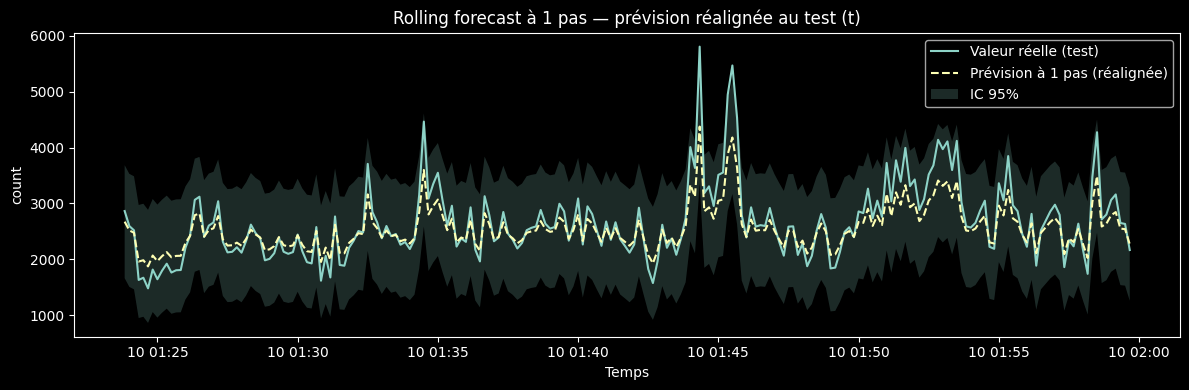

In [123]:
# RMSE (après réalignement)
rmse = np.sqrt(mean_squared_error(y_true_pl, yhat_pl))
print(f"RMSE (après réalignement) = {rmse:.4f}")

# --- Graphique ---
plt.figure(figsize=(12, 4))
plt.plot(y_true_pl.index, y_true_pl, label="Valeur réelle (test)")
plt.plot(yhat_pl.index,  yhat_pl, linestyle="--", label="Prévision à 1 pas (réalignée)")
plt.fill_between(yhat_pl.index, low_pl, high_pl, alpha=0.2, label="IC 95%")
plt.title("Rolling forecast à 1 pas — prévision réalignée au test (t)")
plt.xlabel("Temps")
plt.ylabel(endog_name if isinstance(endog_name, str) else "valeur")
plt.legend()
plt.tight_layout()
plt.show()

### Test en RMSE

In [124]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error

# --- Rolling avec modèle ARIMA déjà entraîné (res_ar_rmse) ---
res_rmse = res_ar_rmse  # modèle pré-entraîné sur y_train
endog_name = res_rmse.model.endog_names  # nom de la variable endog d'origine

# Sécurise le test (facultatif si déjà propre)
y_test = y_test.sort_index().dropna()

# Conteneurs
rolling_preds_rmse = []
conf_low_rmse = []
conf_high_rmse = []
idxs_rmse = []

# Boucle rolling
for ts, y_true in y_test.items():  # ts = timestamp / index, y_true = valeur
    # 1) Prévision à 1 pas (cible t+1)
    fc = res_rmse.get_forecast(steps=1)
    yhat = fc.predicted_mean.iloc[0]
    ci = fc.conf_int(alpha=0.05)
    lower, upper = ci.iloc[0, 0], ci.iloc[0, 1]

    # 2) Utilise l'INDEX CIBLE renvoyé par statsmodels (évite le lag)
    idx_target = fc.predicted_mean.index[0]
    rolling_preds_rmse.append(yhat)
    conf_low_rmse.append(lower)
    conf_high_rmse.append(upper)
    idxs_rmse.append(idx_target)

    # 3) Mise à jour du modèle avec l'observation réelle à ts
    new_obs = pd.Series([y_true], index=[ts], name=endog_name)
    res_rmse = res_rmse.append(new_obs, refit=False)

In [125]:
# Séries indexées par la date cible (t)
yhat_series_rmse = pd.Series(rolling_preds_rmse, index=idxs_rmse, name="yhat")
low_series_rmse  = pd.Series(conf_low_rmse,     index=idxs_rmse, name="lower")
high_series_rmse = pd.Series(conf_high_rmse,    index=idxs_rmse, name="upper")

# --- RMSE sur l'intersection des index (pas de shift nécessaire) ---
common = y_test.index.intersection(yhat_series_rmse.index)
rmse_rolling_rmse = np.sqrt(mean_squared_error(y_test.loc[common], yhat_series_rmse.loc[common]))
print(f"RMSE ARIMA rolling (aligné cible) = {rmse_rolling_rmse:.4f}")

RMSE ARIMA rolling (aligné cible) = 513.0496


In [127]:
# Pas temporel connu
step = pd.Timedelta(seconds=10)

# 1) Décalage des index d'un pas vers l'arrière
yhat_aligned_rmse = yhat_series_rmse.copy()
yhat_aligned_rmse.index = yhat_aligned_rmse.index - step

low_aligned_rmse = low_series_rmse.copy()
low_aligned_rmse.index = low_aligned_rmse.index - step

high_aligned_rmse = high_series_rmse.copy()
high_aligned_rmse.index = high_aligned_rmse.index - step

# 2) Comparaison sur l’intersection
common = y_test.index.intersection(yhat_aligned_rmse.index)

rmse_rolling_rmse = np.sqrt(
    mean_squared_error(y_test.loc[common], yhat_aligned_rmse.loc[common])
)

print(f"RMSE ARIMA rolling (après réalignement) = {rmse_rolling_rmse:.4f}")

RMSE ARIMA rolling (après réalignement) = 290.0152


### Comparaison de la prévision

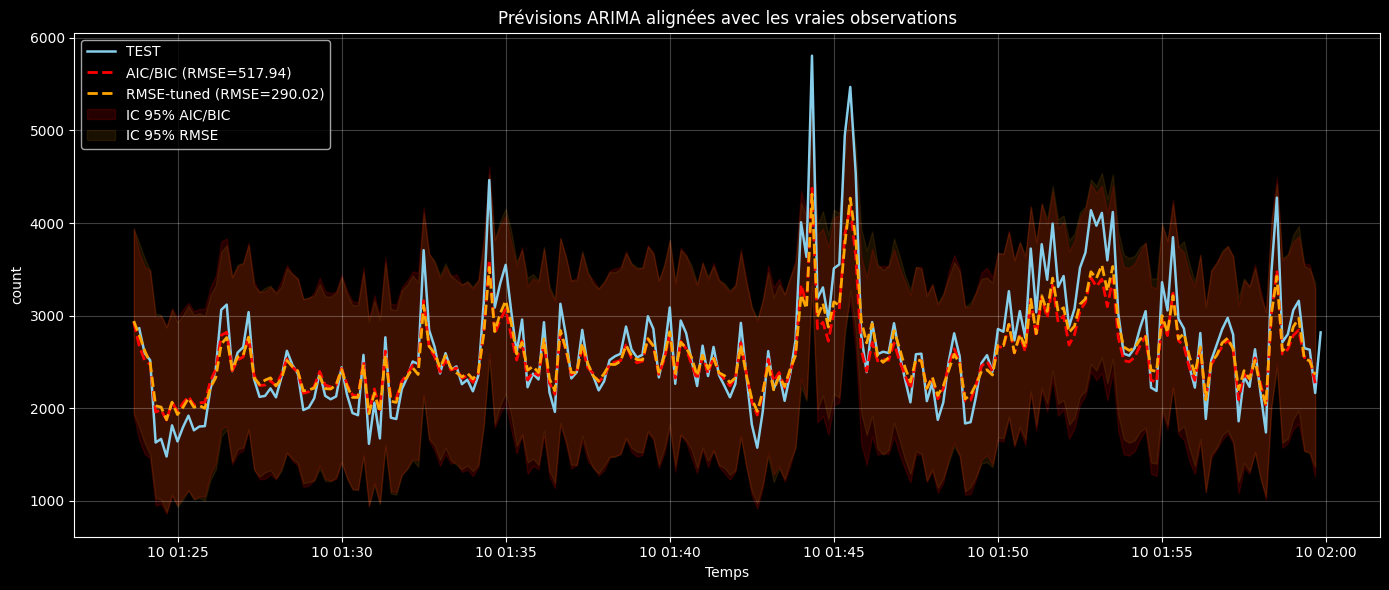

In [128]:
plt.figure(figsize=(14,6))

# Série réelle de test
plt.plot(y_test.index, y_test.values,
         color="#87CEEB", linewidth=1.8, label="TEST")

# Prévisions ARIMA AIC/BIC alignées
plt.plot(yhat_aligned_aic_bic.dropna().index,
         yhat_aligned_aic_bic.dropna().values,
         color="red", linewidth=2, linestyle="--",
         label=f"AIC/BIC (RMSE={rmse_rolling_aic:.2f})")

# Prévisions ARIMA RMSE alignées
plt.plot(yhat_aligned_rmse.dropna().index,
         yhat_aligned_rmse.dropna().values,
         color="orange", linewidth=2, linestyle="--",
         label=f"RMSE-tuned (RMSE={rmse_rolling_rmse:.2f})")

# Bandes de confiance AIC/BIC alignées
plt.fill_between(low_aligned_aic_bic.dropna().index,
                 low_aligned_aic_bic.dropna().values,
                 high_aligned_aic_bic.dropna().values,
                 color="red", alpha=0.15, label="IC 95% AIC/BIC")

# Bandes de confiance RMSE alignées
plt.fill_between(low_aligned_rmse.dropna().index,
                 low_aligned_rmse.dropna().values,
                 high_aligned_rmse.dropna().values,
                 color="orange", alpha=0.1, label="IC 95% RMSE")

# Mise en forme
plt.title("Prévisions ARIMA alignées avec les vraies observations")
plt.xlabel("Temps")
plt.ylabel(endog_name if isinstance(endog_name, str) else "Valeur")
plt.legend(loc="upper left")
plt.grid(alpha=0.25)
plt.tight_layout()
plt.show()

Le RMSE obtenu à partir de AIC/BIC est de 518 avec le modèle AR(1) contre 512 pour le RMSE avec le modèle AR(13). Le Backtesting maximise alors la prévision maix au prix d'un modèle compliqué. 

Vu que la différence de performance n'est pas si éloignée, nous préférons AR(1), un modèle parcimonieux mais efficace.

Pour le streaming suivant, essayons d'illustrer l'évolution des deux modèles néanmoins.

# Prolongation en Streaming

In [131]:
# RMSE cumulés (sur les index communs et réalignés)
common_aic  = y_test.index[:i].intersection(yhat_aligned_aic_bic.index[:i])
common_rmse = y_test.index[:i].intersection(yhat_aligned_rmse.index[:i])

if len(common_aic) > 0:
    rmse_aic = np.sqrt(mean_squared_error(y_test.loc[common_aic],
                                          yhat_aligned_aic_bic.loc[common_aic]))
else:
    rmse_aic = np.nan

if len(common_rmse) > 0:
    rmse_rmse = np.sqrt(mean_squared_error(y_test.loc[common_rmse],
                                           yhat_aligned_rmse.loc[common_rmse]))
else:
    rmse_rmse = np.nan

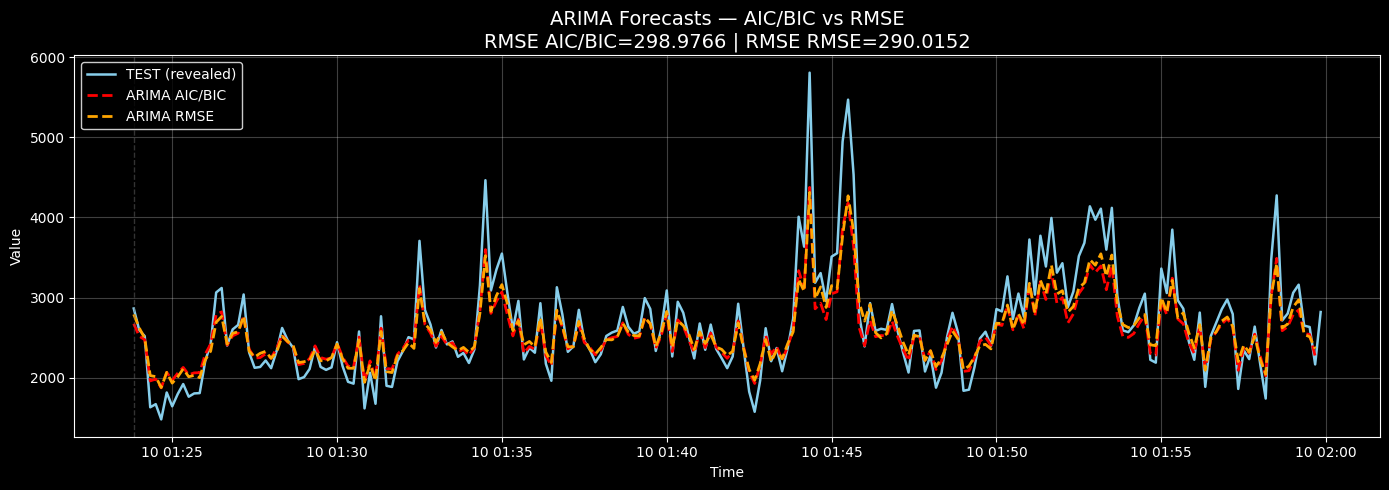

In [ ]:
import time
from IPython.display import clear_output, display
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

plt.style.use("dark_background")
step_delay = 0.00001  # seconds between frames

fig, ax = plt.subplots(figsize=(14, 5))
fig.patch.set_facecolor("black")
ax.set_facecolor("black")

for i in range(1, len(y_test) + 1):
    ax.cla()

    # Visible window at time i
    idx_vis = y_test.index[:i]

    # TEST (cyan)
    y_true_vis = y_test.reindex(idx_vis)
    ax.plot(idx_vis, y_true_vis.values,
            linewidth=1.8, label="TEST (revealed)", color="#87CEEB")

    # --- AIC/BIC (red)
    yhat_aic_vis = yhat_aligned_aic_bic.reindex(idx_vis)
    ax.plot(idx_vis, yhat_aic_vis.values,
            linewidth=2, linestyle="--", label="ARIMA AIC/BIC", color="red")

    # --- RMSE (orange)
    yhat_rmse_vis = yhat_aligned_rmse.reindex(idx_vis)
    ax.plot(idx_vis, yhat_rmse_vis.values,
            linewidth=2, linestyle="--", label="ARIMA RMSE", color="orange")

    # Train/test split
    ax.axvline(y_test.index[0], linestyle="--", linewidth=1, alpha=0.5, color="#666666")

    # Cumulative RMSE (on available common indices)
    common_aic  = idx_vis.intersection(yhat_aligned_aic_bic.index)
    common_rmse = idx_vis.intersection(yhat_aligned_rmse.index)

    rmse_aic = (np.sqrt(mean_squared_error(y_test.loc[common_aic],
                                           yhat_aligned_aic_bic.loc[common_aic]))
                if len(common_aic) > 0 else np.nan)

    rmse_rmse = (np.sqrt(mean_squared_error(y_test.loc[common_rmse],
                                            yhat_aligned_rmse.loc[common_rmse]))
                 if len(common_rmse) > 0 else np.nan)

    # Title (no t counter, no IC)
    ax.set_title(
        f"ARIMA Forecasts — AIC/BIC vs RMSE\n"
        f"RMSE AIC/BIC={rmse_aic:.4f} | RMSE RMSE={rmse_rmse:.4f}",
        color="white", fontsize=14
    )
    
    # Axes
    ax.set_xlabel("Time", color="white")
    ax.set_ylabel("Value", color="white")
    ax.tick_params(colors="white")
    ax.legend(loc="upper left", facecolor="black", edgecolor="white", labelcolor="white")
    ax.grid(alpha=0.25)

    fig.tight_layout()
    clear_output(wait=True)
    display(fig)
    time.sleep(step_delay)

plt.close(fig)